In [ ]:
# Install required packages
!pip install ctgan tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.9 MB/s eta 0:00:00


In [ ]:
# Import required libraries (consistent with provided notebook)
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import time
import random
from numpy import array
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score
from sklearn.model_selection import train_test_split

# Additional imports for adversarial attacks, GANs, and TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from ctgan import CTGAN
from sklearn.metrics import classification_report

In [ ]:
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
path = '/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/MachineLearningCVE'
all_files = glob.glob(path + "/*.csv")
dataset = pd.concat((pd.read_csv(f) for f in all_files))
dataset.to_csv('combined_dataset.csv', index=False)

In [ ]:
# Assign column names
col_names = ["Destination_Port", "Flow_Duration", "Total_Fwd_Packets", "Total_Backward_Packets",
             "Total_Length_of_Fwd_Packets", "Total_Length_of_Bwd_Packets", "Fwd_Packet_Length_Max",
             "Fwd_Packet_Length_Min", "Fwd_Packet_Length_Mean", "Fwd_Packet_Length_Std",
             "Bwd_Packet_Length_Max", "Bwd_Packet_Length_Min", "Bwd_Packet_Length_Mean",
             "Bwd_Packet_Length_Std", "Flow_Bytes_s", "Flow_Packets_s", "Flow_IAT_Mean",
             "Flow_IAT_Std", "Flow_IAT_Max", "Flow_IAT_Min", "Fwd_IAT_Total", "Fwd_IAT_Mean",
             "Fwd_IAT_Std", "Fwd_IAT_Max", "Fwd_IAT_Min", "Bwd_IAT_Total", "Bwd_IAT_Mean",
             "Bwd_IAT_Std", "Bwd_IAT_Max", "Bwd_IAT_Min", "Fwd_PSH_Flags", "Bwd_PSH_Flags",
             "Fwd_URG_Flags", "Bwd_URG_Flags", "Fwd_Header_Length", "Bwd_Header_Length",
             "Fwd_Packets_s", "Bwd_Packets_s", "Min_Packet_Length", "Max_Packet_Length",
             "Packet_Length_Mean", "Packet_Length_Std", "Packet_Length_Variance", "FIN_Flag_Count",
             "SYN_Flag_Count", "RST_Flag_Count", "PSH_Flag_Count", "ACK_Flag_Count",
             "URG_Flag_Count", "CWE_Flag_Count", "ECE_Flag_Count", "Down_Up_Ratio",
             "Average_Packet_Size", "Avg_Fwd_Segment_Size", "Avg_Bwd_Segment_Size",
             "Fwd_Header_Length.1", "Fwd_Avg_Bytes_Bulk", "Fwd_Avg_Packets_Bulk",
             "Fwd_Avg_Bulk_Rate", "Bwd_Avg_Bytes_Bulk", "Bwd_Avg_Packets_Bulk",
             "Bwd_Avg_Bulk_Rate", "Subflow_Fwd_Packets", "Subflow_Fwd_Bytes",
             "Subflow_Bwd_Packets", "Subflow_Bwd_Bytes", "Init_Win_bytes_forward",
             "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward",
             "Active_Mean", "Active_Std", "Active_Max", "Active_Min", "Idle_Mean",
             "Idle_Std", "Idle_Max", "Idle_Min", "Label"]
dataset.columns = col_names

In [ ]:
# Handle missing and infinite values
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.dropna(inplace=True)
dataset = dataset.loc[:, ~dataset.columns.duplicated()]

In [ ]:
dataset.loc[dataset.Label == 'Web Attack � Brute Force', ['Label']] = 'Brute Force'
dataset.loc[dataset.Label == 'Web Attack � XSS', ['Label']] = 'XSS'
dataset.loc[dataset.Label == 'Web Attack � Sql Injection', ['Label']] = 'Injection'

In [ ]:
# Proposed Groupings
attack_group = {'BENIGN': 'benign',
              'DoS Hulk': 'dos',
              'PortScan': 'probe',
              'DDoS': 'ddos',
              'DoS GoldenEye': 'dos',
              'FTP-Patator': 'brute_force',
              'SSH-Patator': 'brute_force',
              'DoS slowloris': 'dos',
              'DoS Slowhttptest': 'dos',
              'Bot': 'botnet',
              'Brute Force': 'web_attack',
              'XSS': 'web_attack',
              'Heartbleed': 'dos',
              'Injection':'web_attack',
              'Infiltration':'infiltration'
              }
# Create grouped label column
dataset['Label_Category'] = dataset['Label'].map(lambda x: attack_group[x])
dataset['Label_Category'].value_counts()

,count
Label_Category,
benign,2271320
dos,251723
probe,158804
ddos,128025
brute_force,13832
web_attack,2180
botnet,1956
infiltration,36


In [ ]:
# Check for unmapped labels
unmapped_labels = dataset[dataset['Label_Category'].isna()]['Label'].unique()
if len(unmapped_labels) > 0:
    print(f"Warning: Unmapped labels found: {unmapped_labels}")
    dataset = dataset.dropna(subset=['Label_Category'])

In [ ]:
# Print label distribution
print("\nOriginal Label Distribution:")
print(dataset['Label'].value_counts())
print("\nRegrouped Label Distribution:")
print(dataset['Label_Category'].value_counts())


Original Label Distribution:
Label
BENIGN              2271320
DoS Hulk             230124
PortScan             158804
DDoS                 128025
DoS GoldenEye         10293
FTP-Patator            7935
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1956
Brute Force            1507
XSS                     652
Infiltration             36
Injection                21
Heartbleed               11
Name: count, dtype: int64

Regrouped Label Distribution:
Label_Category
benign          2271320
dos              251723
probe            158804
ddos             128025
brute_force       13832
web_attack         2180
botnet             1956
infiltration         36
Name: count, dtype: int64


In [ ]:
# Split dataset
attacks = ['Label', 'Label_Category']
xs = dataset.drop(attacks, axis=1)
ys = dataset[attacks]
x_train, x_temp, y_train, y_temp = train_test_split(xs, ys, test_size=0.4, random_state=0, stratify=ys['Label_Category'])
x_test, x_validate, y_test, y_validate = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp['Label_Category'])

In [ ]:
# Verify no NaN in splits
print("\nChecking for NaN in x_train:", x_train.isna().any().any())
print("Checking for NaN in y_train['Label_Category']:", y_train['Label_Category'].isna().any())


Checking for NaN in x_train: False
Checking for NaN in y_train['Label_Category']: False


In [ ]:
# Drop single-value columns
to_drop = [col for col in x_train.columns if x_train[col].nunique() == 1]
x_train = x_train.drop(to_drop, axis=1)
x_validate = x_validate.drop(to_drop, axis=1)
x_test = x_test.drop(to_drop, axis=1)
xs = xs.drop(to_drop, axis=1)  # Update xs for feature selection

# Normalize
min_max_scaler = MinMaxScaler().fit(x_train)
x_train = min_max_scaler.transform(x_train)
x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

In [ ]:
# column_names = np.array(list(x_train))
# to_drop = []
# for x in column_names:
#   size = x_train.groupby([x]).size()
#   # check for columns that only have one value
#   if (len(size.unique()) == 1):
#       to_drop.append(x)
# to_drop

[]

In [ ]:
# x_train = x_train.drop(to_drop, axis=1)
# x_validate = x_validate.drop(to_drop, axis=1)
# x_test = x_test.drop(to_drop, axis=1)
# dataset_copy = dataset.drop(to_drop, axis=1)

In [ ]:
# Normalize
min_max_scaler = MinMaxScaler().fit(x_train)
x_train = min_max_scaler.transform(x_train)
x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

In [ ]:
# Feature selection
features = SelectKBest(score_func=chi2, k=32)
fit = features.fit(x_train, y_train['Label_Category'])
x_train = fit.transform(x_train)
x_test = fit.transform(x_test)
x_validate = fit.transform(x_validate)
selected_features = xs.columns[fit.get_support()].tolist()

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train['Label_Category'])
y_test_encoded = le.transform(y_test['Label_Category'])
y_validate_encoded = le.transform(y_validate['Label_Category'])

# Verify test set
print("\nTest Set Size:", x_test.shape)
print("Test Set Class Distribution:")
print(pd.Series(le.inverse_transform(y_test_encoded)).value_counts())


Test Set Size: (565575, 32)
Test Set Class Distribution:
benign          454264
dos              50344
probe            31761
ddos             25605
brute_force       2767
web_attack         436
botnet             391
infiltration         7
Name: count, dtype: int64


section2

Baseline NIDS Training Time: 791.79 seconds
Training Time: 791.79, Validation Time: 8.49, Testing Time: 10.83 seconds

Baseline NIDS Classification Report (All Classes):
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00    454264
      botnet       0.83      0.77      0.80       391
 brute_force       1.00      1.00      1.00      2767
        ddos       1.00      1.00      1.00     25605
         dos       1.00      1.00      1.00     50344
infiltration       1.00      0.57      0.73         7
       probe       0.99      1.00      0.99     31761
  web_attack       0.99      0.97      0.98       436

    accuracy                           1.00    565575
   macro avg       0.98      0.91      0.94    565575
weighted avg       1.00      1.00      1.00    565575



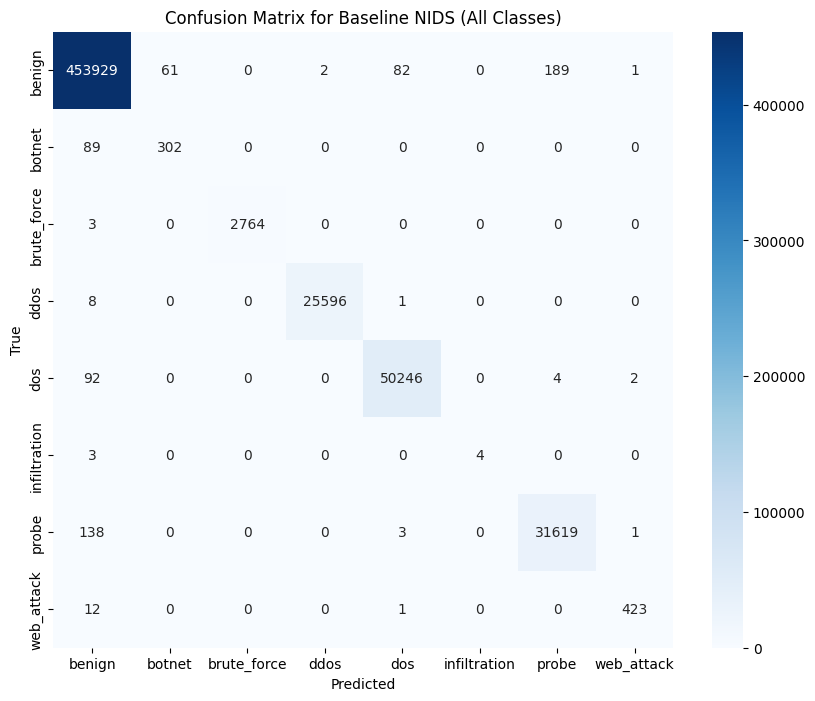

In [ ]:
# Train Baseline NIDS
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
start = time.time()
classifier.fit(x_train, y_train_encoded)
end = time.time()
training_time = end - start
print(f"Baseline NIDS Training Time: {training_time:.2f} seconds")

# Validate
start = time.time()
y_validate_predicted = classifier.predict(x_validate)
end = time.time()
predict_time = end - start

# Test
start = time.time()
y_test_predicted = classifier.predict(x_test)
end = time.time()
testing_time = end - start
print(f"Training Time: {training_time:.2f}, Validation Time: {predict_time:.2f}, Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nBaseline NIDS Classification Report (All Classes):")
print(classification_report(y_test_encoded, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf_1 = confusion_matrix(y_test_encoded, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf_1, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Baseline NIDS (All Classes)')
plt.show()

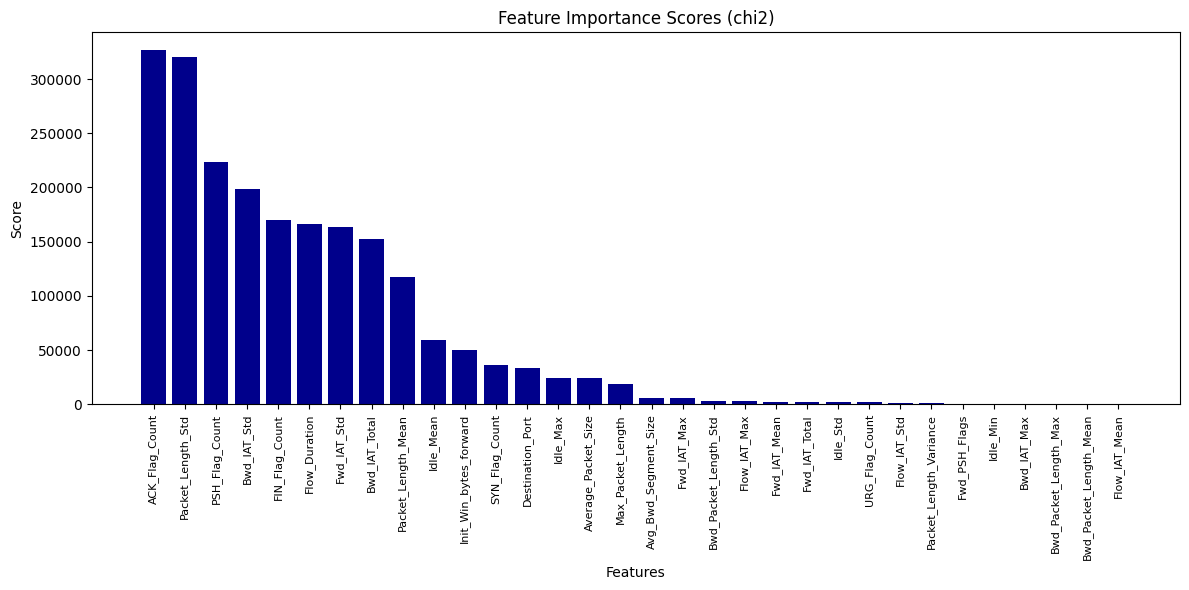

In [ ]:
# Feature importance visualization
feature_importances = zip(selected_features, fit.scores_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
plt.title('Feature Importance Scores (chi2)')
plt.xlabel('Features')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('features.png', dpi=400)
plt.show()

#Section 3 GAN Ensemble


In [ ]:
!pip install ctgan --upgrade

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from ctgan import CTGAN
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [ ]:
# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# Subsample for speed (optional, remove if you want all vulnerable samples)
subset_indices = np.random.choice(len(x_train_vuln), min(5000, len(x_train_vuln)), replace=False)
x_train_vuln = x_train_vuln[subset_indices]
y_train_vuln = y_train_vuln[subset_indices]
print("Subsampled Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

TensorFlow GPUs: 0


NameError: name 'torch' is not defined

TensorFlow GPUs: 1
PyTorch CUDA Available: True
GPU Name: NVIDIA L4
Vulnerable Classes Training Data Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Subsampled Vulnerable Classes Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Iteration 1/2
Training GAN 1 (VanillaGAN)
Vanilla GAN Epoch 0/20, Time: 3.11 seconds
Vanilla GAN Epoch 5/20, Time: 0.01 seconds
Vanilla GAN Epoch 10/20, Time: 0.01 seconds
Vanilla GAN Epoch 15/20, Time: 0.01 seconds
Training VanillaGAN took 3.43 seconds
Generated samples shape: (500, 32)
Label assignment took 10.21 seconds
RandomForestClassifier fit took 300.17 seconds
GAN 1 Training Accuracy: 0.9988
Training GAN 2 (WGANGP)
WGAN-GP Epoch 0/20, Time: 2.09 seconds
WGAN-GP Epoch 5/20, Time: 0.01 seconds
WGAN-GP Epoch 10/20, Time: 0.01 seconds
WGAN-GP Epoch 15/20, Time: 0.01 seconds
Training WGANGP took 2.41 seconds
Generated samples shape: (500, 32)
Label assignment took 10.39 seconds
RandomForestCl

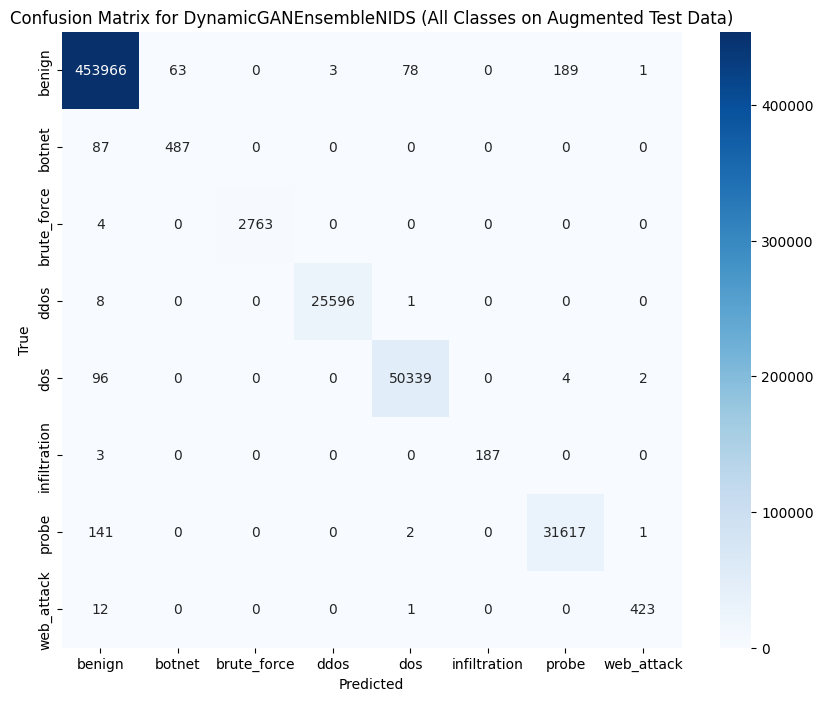

Total execution time: 2470.95 seconds


In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# Subsample for speed (optional, remove if you want all vulnerable samples)
subset_indices = np.random.choice(len(x_train_vuln), min(5000, len(x_train_vuln)), replace=False)
x_train_vuln = x_train_vuln[subset_indices]
y_train_vuln = y_train_vuln[subset_indices]
print("Subsampled Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Added back
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)  # Convert to tensor
        return self.generator([noise, labels_onehot]).numpy()

# DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=50, random_state=0)  # Reduced n_estimators
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.infiltration_label = le.transform(['infiltration'])[0]  # e.g., 5
        self.botnet_label = le.transform(['botnet'])[0]             # e.g., 1

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                # Remap y_train to 0 and 1 for ConditionalGAN
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                  np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores:
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, n_samples=500, n_iterations=2):
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=X_train.columns)

        # Remap labels for ConditionalGAN to 0 (infiltration) and 1 (botnet)
        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                   np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, X_train_cond if isinstance(gan, ConditionalGAN) else X_train,
                                    y_train_cond if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue
                # Generate class-specific samples for CGAN
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),  # infiltration
                        np.full(n_samples_per_class, 1)   # botnet
                    ])
                    samples = self.generate_samples(gan, n_samples, labels)
                    # Remap back to original labels for consistency
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                X_combined = np.vstack((x_train, samples))
                y_combined = np.hstack((y_train_encoded, synthetic_labels))
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")
                score = self.nids_model.score(X_test, y_test)
                iteration_scores.append(score)
                print(f"GAN {i+1} Training Accuracy: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        final_samples = []
        final_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_weighted = int(w * n_samples)
            if n_samples_weighted > 0:
                print(f"Generating {n_samples_weighted} samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_weighted // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),  # infiltration
                        np.full(n_samples_per_class, 1)   # botnet
                    ])
                    samples = self.generate_samples(gan, n_samples_weighted, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_weighted)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples) if final_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_labels = np.hstack(final_labels) if final_labels else np.zeros(0, dtype=np.int64)

        # Augment test data with synthetic samples
        X_test_augmented = np.vstack((x_test, final_samples))
        y_test_augmented = np.hstack((y_test_encoded, final_labels))

        # Evaluate BaselineNIDS
        baseline_nids = RandomForestClassifier(n_estimators=50, random_state=0)
        baseline_nids.fit(x_train, y_train_encoded)
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS
        dynamic_nids = RandomForestClassifier(n_estimators=50, random_state=0)
        X_train_combined = np.vstack((x_train, final_samples))
        y_train_combined = np.hstack((y_train_encoded, final_labels))
        dynamic_nids.fit(X_train_combined, y_train_combined)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Confusion matrix for DynamicGANEnsembleNIDS
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        return final_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=100, epochs=20, batch_size=512)
    final_samples = ensemble.fit(x_train_vuln, y_train_vuln, x_test, y_test_encoded, n_samples=500, n_iterations=2)

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy', final_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

TensorFlow GPUs: 0
PyTorch CUDA Available: False
Vulnerable Classes Training Data Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Subsampled Vulnerable Classes Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Iteration 1/2
Training GAN 1 (VanillaGAN)
Vanilla GAN Epoch 0/20, Time: 10.24 seconds
Vanilla GAN Epoch 5/20, Time: 0.07 seconds
Vanilla GAN Epoch 10/20, Time: 0.09 seconds
Vanilla GAN Epoch 15/20, Time: 0.08 seconds
Training VanillaGAN took 12.20 seconds
Generated samples shape: (500, 32)
Label assignment took 30.27 seconds
RandomForestClassifier fit took 709.98 seconds
GAN 1 Training Accuracy: 0.9987
Training GAN 2 (WGANGP)
WGAN-GP Epoch 0/20, Time: 2.61 seconds
WGAN-GP Epoch 5/20, Time: 0.05 seconds
WGAN-GP Epoch 10/20, Time: 0.05 seconds
WGAN-GP Epoch 15/20, Time: 0.05 seconds
Training WGANGP took 3.54 seconds
Generated samples shape: (500, 32)
Label assignment took 21.08 seconds
RandomForestClassifier fit took

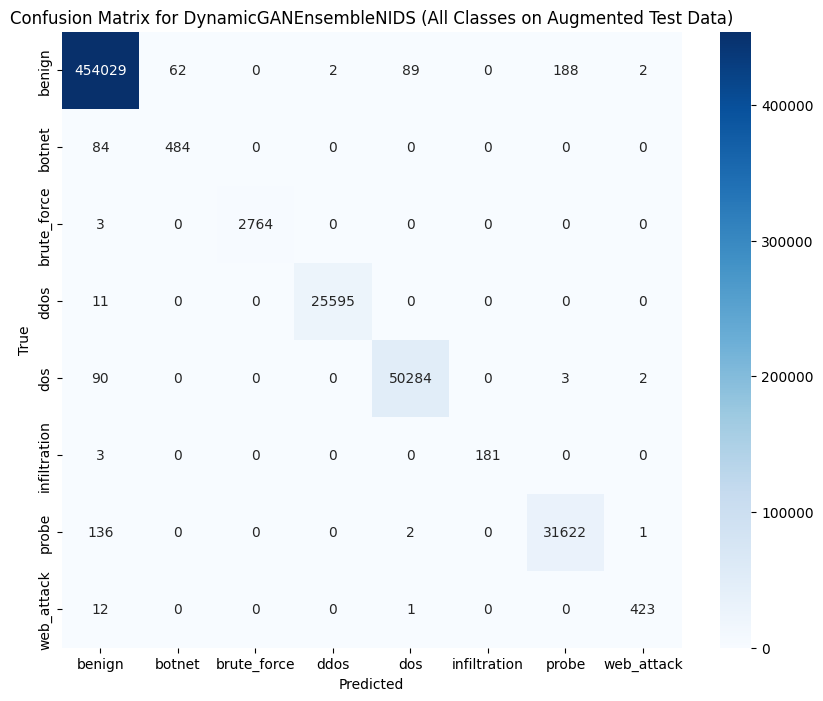

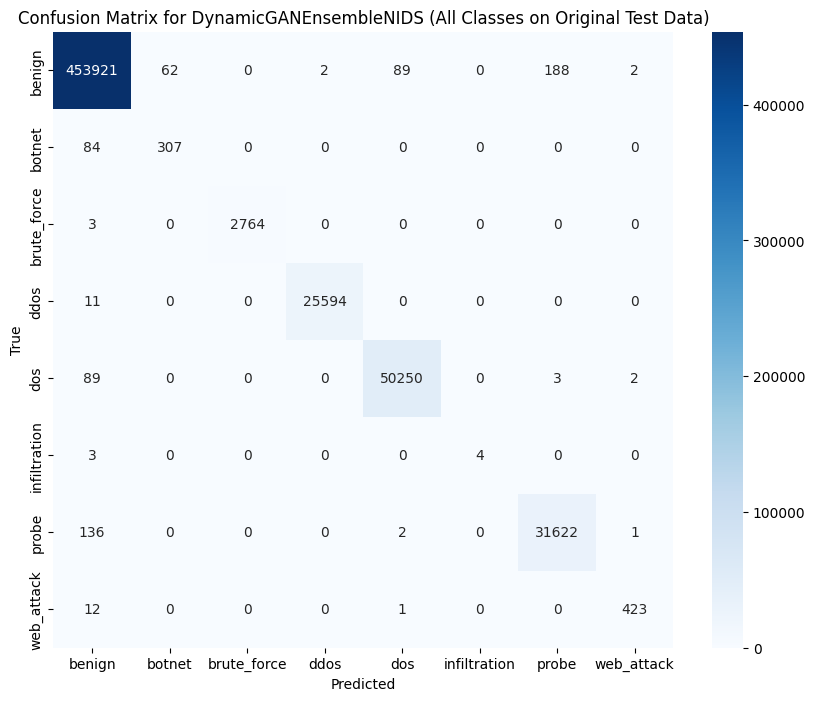

Total execution time: 4245.01 seconds


In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# Subsample for speed (optional, remove if you want all vulnerable samples)
subset_indices = np.random.choice(len(x_train_vuln), min(5000, len(x_train_vuln)), replace=False)
x_train_vuln = x_train_vuln[subset_indices]
y_train_vuln = y_train_vuln[subset_indices]
print("Subsampled Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

# DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.discrete_columns = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=50, random_state=0)
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.infiltration_label = le.transform(['infiltration'])[0]
        self.botnet_label = le.transform(['botnet'])[0]

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores:
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, n_samples=500, n_iterations=2):
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=X_train.columns)

        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, X_train_cond if isinstance(gan, ConditionalGAN) else X_train,
                                     y_train_cond if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                X_combined = np.vstack((x_train, samples))
                y_combined = np.hstack((y_train_encoded, synthetic_labels))
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")
                score = self.nids_model.score(X_test, y_test)
                iteration_scores.append(score)
                print(f"GAN {i+1} Training Accuracy: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        final_samples = []
        final_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_weighted = int(w * n_samples)
            if n_samples_weighted > 0:
                print(f"Generating {n_samples_weighted} samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_weighted // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_weighted, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_weighted)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples) if final_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_labels = np.hstack(final_labels) if final_labels else np.zeros(0, dtype=np.int64)

        # Augment test data with synthetic samples
        X_test_augmented = np.vstack((x_test, final_samples))
        y_test_augmented = np.hstack((y_test_encoded, final_labels))

        # Evaluate BaselineNIDS on augmented test data
        baseline_nids = RandomForestClassifier(n_estimators=50, random_state=0)
        baseline_nids.fit(x_train, y_train_encoded)
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS on augmented test data
        dynamic_nids = RandomForestClassifier(n_estimators=50, random_state=0)
        X_train_combined = np.vstack((x_train, final_samples))
        y_train_combined = np.hstack((y_train_encoded, final_labels))
        dynamic_nids.fit(X_train_combined, y_train_combined)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Additional evaluation of DynamicGANEnsembleNIDS on original test data
        y_pred_dynamic_original = dynamic_nids.predict(X_test)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Original Test Data):")
        print(classification_report(y_test, y_pred_dynamic_original, target_names=le.classes_, zero_division=0))

        # Confusion matrix for DynamicGANEnsembleNIDS on augmented test data
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        # Confusion matrix for DynamicGANEnsembleNIDS on original test data
        cm_dynamic_original = confusion_matrix(y_test, y_pred_dynamic_original)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic_original, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Original Test Data)')
        plt.show()

        return final_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=100, epochs=20, batch_size=512)
    final_samples = ensemble.fit(x_train_vuln, y_train_vuln, x_test, y_test_encoded, n_samples=500, n_iterations=2)

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy', final_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

TensorFlow GPUs: 0
PyTorch CUDA Available: False
Vulnerable Classes Training Data Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Subsampled Vulnerable Classes Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Balanced Vulnerable Classes Distribution:
1    1174
5    1174
Name: count, dtype: int64
Iteration 1/2
Training GAN 1 (VanillaGAN)
Vanilla GAN Epoch 0/100, Time: 10.55 seconds
Vanilla GAN Epoch 5/100, Time: 0.09 seconds
Vanilla GAN Epoch 10/100, Time: 0.16 seconds
Vanilla GAN Epoch 15/100, Time: 0.07 seconds
Vanilla GAN Epoch 20/100, Time: 0.10 seconds
Vanilla GAN Epoch 25/100, Time: 0.11 seconds
Vanilla GAN Epoch 30/100, Time: 0.10 seconds
Vanilla GAN Epoch 35/100, Time: 0.15 seconds
Vanilla GAN Epoch 40/100, Time: 0.10 seconds
Vanilla GAN Epoch 45/100, Time: 0.07 seconds
Vanilla GAN Epoch 50/100, Time: 0.06 seconds
Vanilla GAN Epoch 55/100, Time: 0.06 seconds
Vanilla GAN Epoch 60/100, Time: 0.06 seconds
Vanilla GA

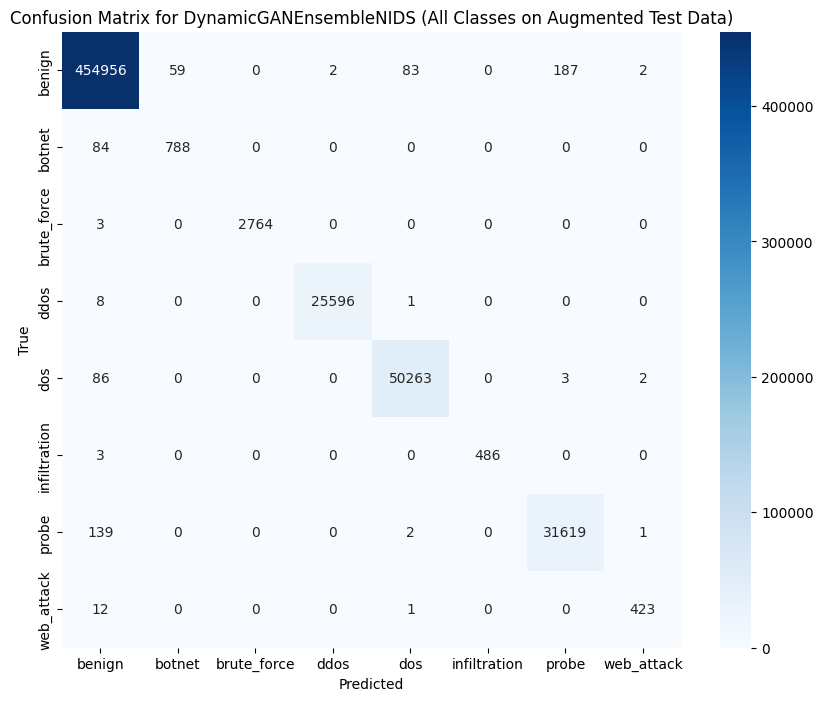

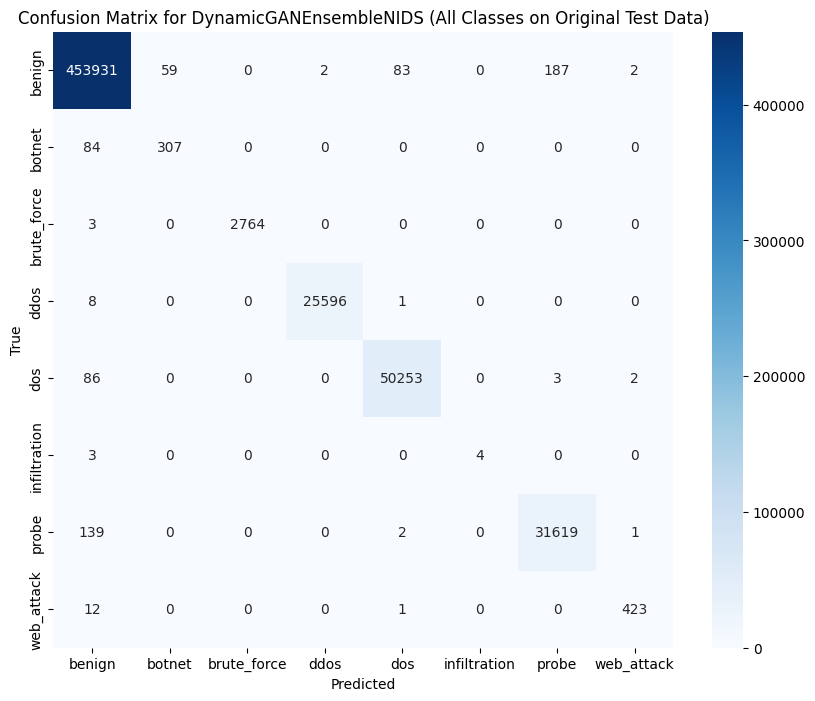

Total execution time: 10621.41 seconds


In [ ]:
from sklearn.utils import resample
from sklearn.metrics import f1_score

import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# Subsample for speed (optional, remove if you want all vulnerable samples)
subset_indices = np.random.choice(len(x_train_vuln), min(5000, len(x_train_vuln)), replace=False)
x_train_vuln = x_train_vuln[subset_indices]
y_train_vuln = y_train_vuln[subset_indices]
print("Subsampled Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

# DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.discrete_columns = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=100, random_state=0)
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.infiltration_label = le.transform(['infiltration'])[0]
        self.botnet_label = le.transform(['botnet'])[0]

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores:
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, n_samples=2000, n_iterations=2):
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=X_train.columns)

        # Balance the vulnerable classes by oversampling infiltration
        inf_indices = y_train == self.infiltration_label
        bot_indices = y_train == self.botnet_label
        X_inf = X_train[inf_indices]
        y_inf = y_train[inf_indices]
        X_bot = X_train[bot_indices]
        y_bot = y_train[bot_indices]
        n_bot = len(X_bot)
        n_inf = len(X_inf)
        if n_inf < n_bot:
            X_inf_oversampled = resample(X_inf, replace=True, n_samples=n_bot - n_inf, random_state=0)
            y_inf_oversampled = resample(y_inf, replace=True, n_samples=n_bot - n_inf, random_state=0)
            X_train = pd.concat([X_train, X_inf_oversampled])
            y_train = np.hstack((y_train, y_inf_oversampled))
        print("Balanced Vulnerable Classes Distribution:")
        print(pd.Series(y_train).value_counts())

        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, X_train_cond if isinstance(gan, ConditionalGAN) else X_train,
                                     y_train_cond if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                X_combined = np.vstack((x_train, samples))
                y_combined = np.hstack((y_train_encoded, synthetic_labels))
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")
                y_pred = self.nids_model.predict(X_test)
                vulnerable_classes_encoded = [self.botnet_label, self.infiltration_label]
                mask = np.isin(y_test, vulnerable_classes_encoded)
                if np.sum(mask) > 0:
                    score = f1_score(y_test[mask], y_pred[mask], average='macro', labels=vulnerable_classes_encoded)
                else:
                    score = 0
                iteration_scores.append(score)
                print(f"GAN {i+1} Vulnerable F1 Score: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        final_samples = []
        final_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_weighted = int(w * n_samples)
            if n_samples_weighted > 0:
                print(f"Generating {n_samples_weighted} samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_weighted // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_weighted, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_weighted)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples) if final_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_labels = np.hstack(final_labels) if final_labels else np.zeros(0, dtype=np.int64)

        # Augment test data with synthetic samples
        X_test_augmented = np.vstack((x_test, final_samples))
        y_test_augmented = np.hstack((y_test_encoded, final_labels))

        # Evaluate BaselineNIDS on augmented test data
        baseline_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        baseline_nids.fit(x_train, y_train_encoded)
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS on augmented test data
        dynamic_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        X_train_combined = np.vstack((x_train, final_samples))
        y_train_combined = np.hstack((y_train_encoded, final_labels))
        dynamic_nids.fit(X_train_combined, y_train_combined)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Additional evaluation of DynamicGANEnsembleNIDS on original test data
        y_pred_dynamic_original = dynamic_nids.predict(X_test)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Original Test Data):")
        print(classification_report(y_test, y_pred_dynamic_original, target_names=le.classes_, zero_division=0))

        # Confusion matrix for DynamicGANEnsembleNIDS on augmented test data
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        # Confusion matrix for DynamicGANEnsembleNIDS on original test data
        cm_dynamic_original = confusion_matrix(y_test, y_pred_dynamic_original)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic_original, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Original Test Data)')
        plt.show()

        return final_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=100, epochs=100, batch_size=512)
    final_samples = ensemble.fit(x_train_vuln, y_train_vuln, x_test, y_test_encoded, n_samples=2000, n_iterations=2)

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy', final_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

# try training gan with all samples of vulnerable classses

TensorFlow GPUs: 0
PyTorch CUDA Available: False
Vulnerable Classes Training Data Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Vulnerable Classes Test Data Distribution:
botnet          391
infiltration      7
Name: count, dtype: int64
Combined Vulnerable Classes Data Distribution:
botnet          1565
infiltration      29
Name: count, dtype: int64
Subsampled Vulnerable Classes Distribution:
botnet          1565
infiltration      29
Name: count, dtype: int64
Balanced Vulnerable Classes Distribution:
1    1565
5    1565
Name: count, dtype: int64
Iteration 1/2
Training GAN 1 (VanillaGAN)
Vanilla GAN Epoch 0/100, Time: 6.79 seconds
Vanilla GAN Epoch 5/100, Time: 0.64 seconds
Vanilla GAN Epoch 10/100, Time: 0.51 seconds
Vanilla GAN Epoch 15/100, Time: 0.25 seconds
Vanilla GAN Epoch 20/100, Time: 0.23 seconds
Vanilla GAN Epoch 25/100, Time: 0.23 seconds
Vanilla GAN Epoch 30/100, Time: 0.31 seconds
Vanilla GAN Epoch 35/100, Time: 0.18 seconds
Vanilla GAN 

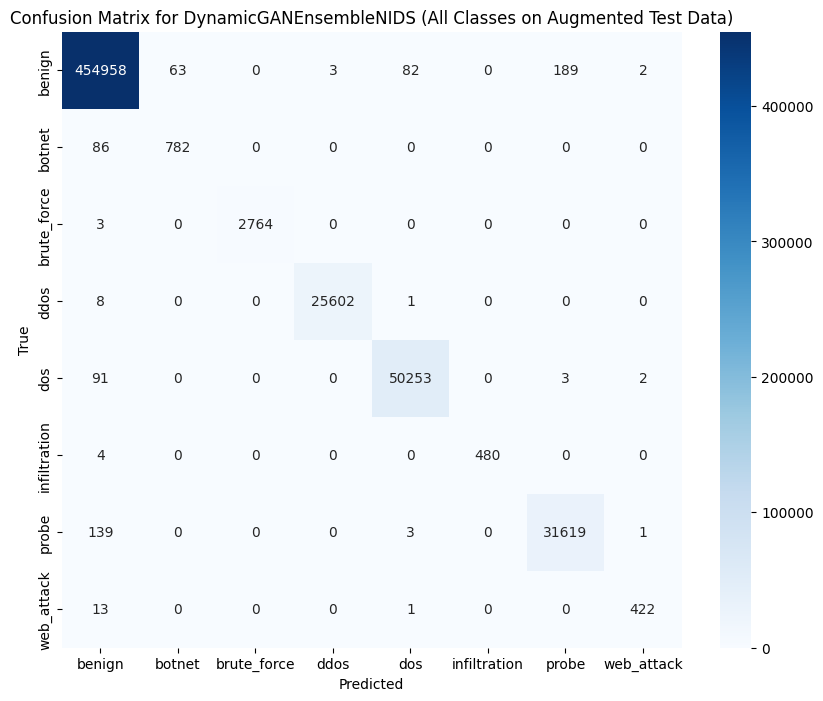

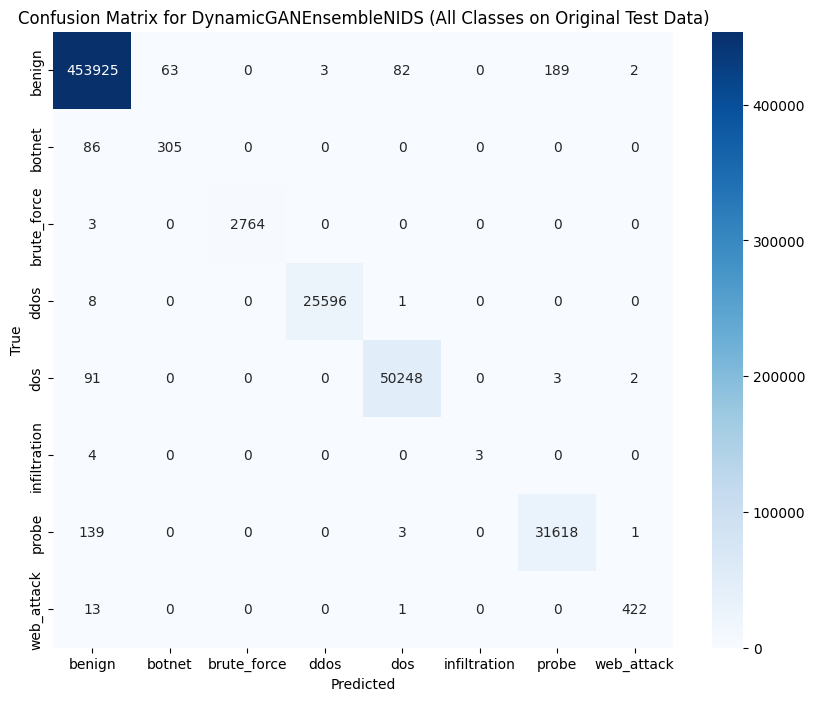

Total execution time: 10675.09 seconds


In [ ]:
from sklearn.utils import resample
from sklearn.metrics import f1_score

import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# Filter test data for vulnerable classes
vulnerable_indices_test = np.isin(le.inverse_transform(y_test_encoded), vulnerable_classes)
x_test_vuln = x_test[vulnerable_indices_test]
y_test_vuln = y_test_encoded[vulnerable_indices_test]
print("Vulnerable Classes Test Data Distribution:")
print(pd.Series(le.inverse_transform(y_test_vuln)).value_counts())

# Combine vulnerable samples from train and test
x_vuln = np.vstack((x_train_vuln, x_test_vuln))
y_vuln = np.hstack((y_train_vuln, y_test_vuln))
print("Combined Vulnerable Classes Data Distribution:")
print(pd.Series(le.inverse_transform(y_vuln)).value_counts())

# Subsample for speed (optional, remove if you want all vulnerable samples)
subset_indices = np.random.choice(len(x_vuln), min(5000, len(x_vuln)), replace=False)
x_vuln = x_vuln[subset_indices]
y_vuln = y_vuln[subset_indices]
print("Subsampled Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_vuln)).value_counts())

# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

# DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.discrete_columns = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=100, random_state=0)
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.infiltration_label = le.transform(['infiltration'])[0]
        self.botnet_label = le.transform(['botnet'])[0]

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores:
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, n_samples=2000, n_iterations=2):
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=X_train.columns)

        # Balance the vulnerable classes by oversampling infiltration
        inf_indices = y_train == self.infiltration_label
        bot_indices = y_train == self.botnet_label
        X_inf = X_train[inf_indices]
        y_inf = y_train[inf_indices]
        X_bot = X_train[bot_indices]
        y_bot = y_train[bot_indices]
        n_bot = len(X_bot)
        n_inf = len(X_inf)
        if n_inf < n_bot:
            X_inf_oversampled = resample(X_inf, replace=True, n_samples=n_bot - n_inf, random_state=0)
            y_inf_oversampled = resample(y_inf, replace=True, n_samples=n_bot - n_inf, random_state=0)
            X_train = pd.concat([X_train, X_inf_oversampled])
            y_train = np.hstack((y_train, y_inf_oversampled))
        print("Balanced Vulnerable Classes Distribution:")
        print(pd.Series(y_train).value_counts())

        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, X_train_cond if isinstance(gan, ConditionalGAN) else X_train,
                                     y_train_cond if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                X_combined = np.vstack((x_train, samples))
                y_combined = np.hstack((y_train_encoded, synthetic_labels))
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")
                y_pred = self.nids_model.predict(X_test)
                vulnerable_classes_encoded = [self.botnet_label, self.infiltration_label]
                mask = np.isin(y_test, vulnerable_classes_encoded)
                if np.sum(mask) > 0:
                    score = f1_score(y_test[mask], y_pred[mask], average='macro', labels=vulnerable_classes_encoded)
                else:
                    score = 0
                iteration_scores.append(score)
                print(f"GAN {i+1} Vulnerable F1 Score: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        final_samples = []
        final_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_weighted = int(w * n_samples)
            if n_samples_weighted > 0:
                print(f"Generating {n_samples_weighted} samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_weighted // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_weighted, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_weighted)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples) if final_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_labels = np.hstack(final_labels) if final_labels else np.zeros(0, dtype=np.int64)

        # Augment test data with synthetic samples
        X_test_augmented = np.vstack((x_test, final_samples))
        y_test_augmented = np.hstack((y_test_encoded, final_labels))

        # Evaluate BaselineNIDS on augmented test data
        baseline_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        baseline_nids.fit(x_train, y_train_encoded)
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS on augmented test data
        dynamic_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        X_train_combined = np.vstack((x_train, final_samples))
        y_train_combined = np.hstack((y_train_encoded, final_labels))
        dynamic_nids.fit(X_train_combined, y_train_combined)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Additional evaluation of DynamicGANEnsembleNIDS on original test data
        y_pred_dynamic_original = dynamic_nids.predict(X_test)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Original Test Data):")
        print(classification_report(y_test, y_pred_dynamic_original, target_names=le.classes_, zero_division=0))

        # Confusion matrix for DynamicGANEnsembleNIDS on augmented test data
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        # Confusion matrix for DynamicGANEnsembleNIDS on original test data
        cm_dynamic_original = confusion_matrix(y_test, y_pred_dynamic_original)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic_original, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Original Test Data)')
        plt.show()

        return final_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=100, epochs=100, batch_size=512)
    final_samples = ensemble.fit(x_vuln, y_vuln, x_test, y_test_encoded, n_samples=2000, n_iterations=2)

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy', final_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

#99times


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os
import torch

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
vuln_train_dist = pd.Series(le.inverse_transform(y_train_vuln)).value_counts()
print(vuln_train_dist)

# Filter test data for vulnerable classes
vulnerable_indices_test = np.isin(le.inverse_transform(y_test_encoded), vulnerable_classes)
x_test_vuln = x_test[vulnerable_indices_test]
y_test_vuln = y_test_encoded[vulnerable_indices_test]
print("Vulnerable Classes Test Data Distribution:")
vuln_test_dist = pd.Series(le.inverse_transform(y_test_vuln)).value_counts()
print(vuln_test_dist)

# Combine vulnerable samples from train and test for reference
x_vuln = np.vstack((x_train_vuln, x_test_vuln))
y_vuln = np.hstack((y_train_vuln, y_test_vuln))
print("Combined Vulnerable Classes Data Distribution:")
print(pd.Series(le.inverse_transform(y_vuln)).value_counts())

# Store original Botnet samples for final evaluation
botnet_indices = y_vuln == le.transform(['botnet'])[0]
x_orig_botnet = x_vuln[botnet_indices]
y_orig_botnet = y_vuln[botnet_indices]
print(f"Original Botnet Samples: {len(x_orig_botnet)}")
if len(x_orig_botnet) != 1956:
    print(f"Warning: Expected 1,956 Botnet samples, found {len(x_orig_botnet)}")

# WGAN-GP (unchanged)
class WGANGP:
    def __init__(self, latent_dim=100, epochs=50, batch_size=256):  # Reduced epochs and batch_size
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN (unchanged)
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=50, batch_size=256):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN (unchanged)
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=50, batch_size=256):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

# Modified DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=256):
        self.discrete_columns = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=100, random_state=0)
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.infiltration_label = le.transform(['infiltration'])[0]
        self.botnet_label = le.transform(['botnet'])[0]

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None, class_name=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32), np.zeros(n_samples, dtype=np.int64)
                samples = gan.sample(n_samples, labels)
                synthetic_labels = np.full(n_samples, self.botnet_label if class_name == 'botnet' else self.infiltration_label)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32), np.zeros(n_samples, dtype=np.int64)
                samples = gan.sample(n_samples)
                synthetic_labels = self.assign_labels(samples, x_train_vuln, y_train_vuln)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated {n_samples} {class_name} samples from {type(gan).__name__}, shape: {samples.shape}")
            return samples, synthetic_labels
        except Exception as e:
            print(f"Error generating {class_name} samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32), np.zeros(n_samples, dtype=np.int64)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0] if len(y_train) > 0 else 0, dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores or all(s == 0 for s in nids_scores):
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, n_samples_per_class=99, n_iterations=2):
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=X_train.columns)

        # Separate vulnerable and non-vulnerable samples
        inf_indices = y_train == self.infiltration_label
        bot_indices = y_train == self.botnet_label
        non_vuln_indices = ~(inf_indices | bot_indices)
        X_inf = X_train[inf_indices]
        y_inf = y_train[inf_indices]
        X_bot = X_train[bot_indices]
        y_bot = y_train[bot_indices]
        X_non_vuln = X_train[non_vuln_indices]
        y_non_vuln = y_train[non_vuln_indices]
        n_inf = len(X_inf)
        n_bot = len(X_bot)
        print(f"Original Infiltration Samples: {n_inf}, Original Botnet Samples: {n_bot}")

        # Calculate number of synthetic Botnet samples (99 times original)
        n_synthetic_bot = n_bot * n_samples_per_class
        print(f"Generating {n_synthetic_bot} synthetic Botnet samples")

        # Prepare data for Conditional GAN (remap labels: 0 for infiltration, 1 for botnet)
        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, X_train_cond if isinstance(gan, ConditionalGAN) else x_train_vuln,
                                     y_train_cond if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue

                # Generate synthetic Botnet samples
                bot_samples = []
                bot_labels = []
                n_samples_bot = int(self.weights[i] * n_synthetic_bot)
                if n_samples_bot > 0:
                    if isinstance(gan, ConditionalGAN):
                        bot_labels_gen = np.full(n_samples_bot, 1)
                        bot_samp, bot_lab = self.generate_samples(gan, n_samples_bot, bot_labels_gen, 'botnet')
                        bot_samples.append(bot_samp)
                        bot_labels.append(bot_lab)
                    else:
                        samples, synthetic_labels = self.generate_samples(gan, n_samples_bot, class_name='botnet')
                        bot_mask = synthetic_labels == self.botnet_label
                        bot_samples.append(samples[bot_mask][:n_samples_bot])
                        bot_labels.append(synthetic_labels[bot_mask][:n_samples_bot])

                # Combine samples for this GAN
                samples = np.vstack(bot_samples) if bot_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
                synthetic_labels = np.hstack(bot_labels) if bot_labels else np.zeros(0, dtype=np.int64)

                # Create training set: synthetic Botnet samples + original non-Botnet samples
                X_combined = np.vstack((X_non_vuln.values, X_inf.values, samples)) if len(samples) > 0 else np.vstack((X_non_vuln.values, X_inf.values))
                y_combined = np.hstack((y_non_vuln, y_inf, synthetic_labels)) if len(synthetic_labels) > 0 else np.hstack((y_non_vuln, y_inf))

                # Train RF model
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")

                # Evaluate on test set (Botnet class only)
                y_pred = self.nids_model.predict(X_test)
                botnet_mask = y_test == self.botnet_label
                if np.sum(botnet_mask) > 0:
                    score = f1_score(y_test[botnet_mask], y_pred[botnet_mask], average='macro', labels=[self.botnet_label])
                else:
                    score = 0.0
                iteration_scores.append(score)
                print(f"GAN {i+1} Botnet F1 Score: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        # Final synthetic Botnet sample generation
        final_bot_samples = []
        final_bot_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_bot = int(w * n_synthetic_bot)
            if n_samples_bot > 0:
                print(f"Generating {n_samples_bot} botnet samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    bot_labels_gen = np.full(n_samples_bot, 1)
                    bot_samp, bot_lab = self.generate_samples(gan, n_samples_bot, bot_labels_gen, 'botnet')
                    final_bot_samples.append(bot_samp)
                    final_bot_labels.append(bot_lab)
                else:
                    samples, synthetic_labels = self.generate_samples(gan, n_samples_bot, class_name='botnet')
                    bot_mask = synthetic_labels == self.botnet_label
                    final_bot_samples.append(samples[bot_mask][:n_samples_bot])
                    final_bot_labels.append(synthetic_labels[bot_mask][:n_samples_bot])

        final_bot_samples = np.vstack(final_bot_samples) if final_bot_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_bot_labels = np.hstack(final_bot_labels) if final_bot_labels else np.zeros(0, dtype=np.int64)

        # Create final training set: synthetic Botnet samples + original non-Botnet samples
        X_train_final = np.vstack((X_non_vuln.values, X_inf.values, final_bot_samples)) if len(final_bot_samples) > 0 else np.vstack((X_non_vuln.values, X_inf.values))
        y_train_final = np.hstack((y_non_vuln, y_inf, final_bot_labels)) if len(final_bot_labels) > 0 else np.hstack((y_non_vuln, y_inf))

        # Augment test data with synthetic Botnet samples
        X_test_augmented = np.vstack((X_test, final_bot_samples)) if len(final_bot_samples) > 0 else X_test
        y_test_augmented = np.hstack((y_test, final_bot_labels)) if len(final_bot_labels) > 0 else y_test

        # Evaluate BaselineNIDS on augmented test data
        baseline_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        baseline_nids.fit(X_train, y_train)  # Train on original data
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS on augmented test data
        dynamic_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        dynamic_nids.fit(X_train_final, y_train_final)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Evaluate on original test data
        y_pred_dynamic_original = dynamic_nids.predict(X_test)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Original Test Data):")
        print(classification_report(y_test, y_pred_dynamic_original, target_names=le.classes_, zero_division=0))

        # Evaluate on original Botnet samples
        y_pred_orig_botnet = dynamic_nids.predict(x_orig_botnet)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_orig_botnet, y_pred_orig_botnet, labels=[self.botnet_label], average='macro', zero_division=0
        )
        print("\nDynamicGANEnsembleNIDS Classification Report (Original Botnet Samples):")
        print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

        # Evaluate on original vulnerable samples (Botnet + Infiltration)
        y_pred_orig_vuln = dynamic_nids.predict(x_vuln)
        print("\nDynamicGANEnsembleNIDS Classification Report (Original Vulnerable Samples):")
        print(classification_report(y_vuln, y_pred_orig_vuln, target_names=vulnerable_classes, zero_division=0))

        # Confusion matrix for augmented test data
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        # Confusion matrix for original test data
        cm_dynamic_original = confusion_matrix(y_test, y_pred_dynamic_original)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic_original, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Original Test Data)')
        plt.show()

        # Confusion matrix for original Botnet samples
        cm_orig_botnet = confusion_matrix(y_orig_botnet, y_pred_orig_botnet, labels=[self.botnet_label])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_orig_botnet, annot=True, fmt='d', cmap='Blues', xticklabels=['botnet'], yticklabels=['botnet'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (Original Botnet Samples)')
        plt.show()

        # Confusion matrix for original vulnerable samples
        cm_orig_vuln = confusion_matrix(y_vuln, y_pred_orig_vuln, labels=[self.botnet_label, self.infiltration_label])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_orig_vuln, annot=True, fmt='d', cmap='Blues', xticklabels=vulnerable_classes, yticklabels=vulnerable_classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (Original Vulnerable Samples)')
        plt.show()

        return final_bot_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=256)
    final_bot_samples = ensemble.fit(
        x_train, y_train_encoded, x_test, y_test_encoded, n_samples_per_class=99, n_iterations=2
    )

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_botnet_samples.npy', final_bot_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")
    import traceback
    traceback.print_exc()

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

TensorFlow GPUs: 0
PyTorch CUDA Available: False
Vulnerable Classes Training Data Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Vulnerable Classes Test Data Distribution:
botnet          391
infiltration      7
Name: count, dtype: int64
Combined Vulnerable Classes Data Distribution:
botnet          1565
infiltration      29
Name: count, dtype: int64
Original Botnet Samples: 1565
Original Infiltration Samples: 22, Original Botnet Samples: 1174
Generating 116226 synthetic Botnet samples
Iteration 1/2
Training GAN 1 (VanillaGAN)
Vanilla GAN Epoch 0/50, Time: 10.36 seconds
Vanilla GAN Epoch 5/50, Time: 0.07 seconds
Vanilla GAN Epoch 10/50, Time: 0.08 seconds
Vanilla GAN Epoch 15/50, Time: 0.09 seconds
Vanilla GAN Epoch 20/50, Time: 0.07 seconds
Vanilla GAN Epoch 25/50, Time: 0.07 seconds
Vanilla GAN Epoch 30/50, Time: 0.10 seconds
Vanilla GAN Epoch 35/50, Time: 0.08 seconds
Vanilla GAN Epoch 40/50, Time: 0.04 seconds
Vanilla GAN Epoch 45/50, Time: 0.04 s

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# Subsample for speed (optional, remove if you want all vulnerable samples)
subset_indices = np.random.choice(len(x_train_vuln), min(5000, len(x_train_vuln)), replace=False)
x_train_vuln = x_train_vuln[subset_indices]
y_train_vuln = y_train_vuln[subset_indices]
print("Subsampled Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Added back
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)  # Convert to tensor
        return self.generator([noise, labels_onehot]).numpy()

# DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=50, random_state=0)  # Reduced n_estimators
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.infiltration_label = le.transform(['infiltration'])[0]  # e.g., 5
        self.botnet_label = le.transform(['botnet'])[0]             # e.g., 1

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                # Remap y_train to 0 and 1 for ConditionalGAN
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                  np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores:
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, n_samples=500, n_iterations=2):
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=X_train.columns)

        # Remap labels for ConditionalGAN to 0 (infiltration) and 1 (botnet)
        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                   np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, X_train_cond if isinstance(gan, ConditionalGAN) else X_train,
                                    y_train_cond if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue
                # Generate class-specific samples for CGAN
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),  # infiltration
                        np.full(n_samples_per_class, 1)   # botnet
                    ])
                    samples = self.generate_samples(gan, n_samples, labels)
                    # Remap back to original labels for consistency
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                X_combined = np.vstack((x_train, samples))
                y_combined = np.hstack((y_train_encoded, synthetic_labels))
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")
                score = self.nids_model.score(X_test, y_test)
                iteration_scores.append(score)
                print(f"GAN {i+1} Training Accuracy: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        final_samples = []
        final_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_weighted = int(w * n_samples)
            if n_samples_weighted > 0:
                print(f"Generating {n_samples_weighted} samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_weighted // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),  # infiltration
                        np.full(n_samples_per_class, 1)   # botnet
                    ])
                    samples = self.generate_samples(gan, n_samples_weighted, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_weighted)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples) if final_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_labels = np.hstack(final_labels) if final_labels else np.zeros(0, dtype=np.int64)

        # Augment test data with synthetic samples
        X_test_augmented = np.vstack((x_test, final_samples))
        y_test_augmented = np.hstack((y_test_encoded, final_labels))

        # Evaluate BaselineNIDS
        baseline_nids = RandomForestClassifier(n_estimators=50, random_state=0)
        baseline_nids.fit(x_train, y_train_encoded)
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS
        dynamic_nids = RandomForestClassifier(n_estimators=50, random_state=0)
        X_train_combined = np.vstack((x_train, final_samples))
        y_train_combined = np.hstack((y_train_encoded, final_labels))
        dynamic_nids.fit(X_train_combined, y_train_combined)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Confusion matrix for DynamicGANEnsembleNIDS
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        return final_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=100, epochs=20, batch_size=512)
    final_samples = ensemble.fit(x_train_vuln, y_train_vuln, x_test, y_test_encoded, n_samples=500, n_iterations=2)

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy', final_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

TensorFlow GPUs: 0
PyTorch CUDA Available: False
Vulnerable Classes Training Data Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Subsampled Vulnerable Classes Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
Iteration 1/2
Training GAN 1 (VanillaGAN)
Vanilla GAN Epoch 0/20, Time: 2.92 seconds
Vanilla GAN Epoch 5/20, Time: 0.03 seconds
Vanilla GAN Epoch 10/20, Time: 0.03 seconds
Vanilla GAN Epoch 15/20, Time: 0.03 seconds
Training VanillaGAN took 3.91 seconds
Generated samples shape: (500, 32)
Label assignment took 28.44 seconds
RandomForestClassifier fit took 617.29 seconds
GAN 1 Training Accuracy: 0.9987
Training GAN 2 (WGANGP)
WGAN-GP Epoch 0/20, Time: 2.68 seconds
WGAN-GP Epoch 5/20, Time: 0.05 seconds
WGAN-GP Epoch 10/20, Time: 0.05 seconds
WGAN-GP Epoch 15/20, Time: 0.05 seconds
Training WGANGP took 3.79 seconds
Generated samples shape: (500, 32)
Label assignment took 25.05 seconds
RandomForestClassifier fit took 6

KeyboardInterrupt: 

In [ ]:
# Reload trained ensemble and synthetic samples
with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'rb') as f:
    ensemble = pickle.load(f)

final_samples = np.load('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy')

# Evaluate only on vulnerable classes (train+test combined)
dynamic_nids = RandomForestClassifier(n_estimators=100, random_state=0)
X_train_combined = np.vstack((x_train, final_samples))
y_train_combined = np.hstack((y_train_encoded, np.ones(len(final_samples))))  # adjust labels if needed
dynamic_nids.fit(X_train_combined, y_train_combined)

y_pred_vuln = dynamic_nids.predict(x_vuln)
print("\nDynamicGANEnsembleNIDS Classification Report (Only Vulnerable Classes, Train+Test Combined):")
print(classification_report(y_vuln, y_pred_vuln, target_names=vulnerable_classes, zero_division=0))



DynamicGANEnsembleNIDS Classification Report (Only Vulnerable Classes, Train+Test Combined):


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

#on all 1956 and 36

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Print label distribution
print("\nOriginal Label Distribution:")
print(dataset['Label'].value_counts())
print("\nRegrouped Label Distribution:")
print(dataset['Label_Category'].value_counts())

# Split dataset
attacks = ['Label', 'Label_Category']
xs = dataset.drop(attacks, axis=1)
ys = dataset[attacks]
x_train, x_temp, y_train, y_temp = train_test_split(xs, ys, test_size=0.4, random_state=0, stratify=ys['Label_Category'])
x_test, x_validate, y_test, y_validate = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp['Label_Category'])

# Verify no NaN in splits
print("\nChecking for NaN in x_train:", x_train.isna().any().any())
print("Checking for NaN in y_train['Label_Category']:", y_train['Label_Category'].isna().any())

# Drop single-value columns
to_drop = [col for col in x_train.columns if x_train[col].nunique() == 1]
x_train = x_train.drop(to_drop, axis=1)
x_validate = x_validate.drop(to_drop, axis=1)
x_test = x_test.drop(to_drop, axis=1)
xs = xs.drop(to_drop, axis=1)  # Update xs for feature selection

# Normalize
min_max_scaler = MinMaxScaler().fit(x_train)
x_train = min_max_scaler.transform(x_train)
x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

# Feature selection
features = SelectKBest(score_func=chi2, k=32)
fit = features.fit(x_train, y_train['Label_Category'])
x_train = fit.transform(x_train)
x_test = fit.transform(x_test)
x_validate = fit.transform(x_validate)
selected_features = xs.columns[fit.get_support()].tolist()
print("\nSelected features:", selected_features)

# Encode labels for Label_Category
le_category = LabelEncoder()
y_train_encoded = le_category.fit_transform(y_train['Label_Category'])
y_test_encoded = le_category.transform(y_test['Label_Category'])
y_validate_encoded = le_category.transform(y_validate['Label_Category'])

# Encode labels for Label (for Bot and Infiltration)
le = LabelEncoder()
le.fit(dataset['Label'])
print("LabelEncoder classes for Label:", le.classes_)

# Verify test set
print("\nTest Set Size:", x_test.shape)
print("Test Set Class Distribution:")
print(pd.Series(le_category.inverse_transform(y_test_encoded)).value_counts())

# Filter all Bot and Infiltration samples from the original dataset
vulnerable_classes = ['Bot', 'Infiltration']
vuln_indices = dataset['Label'].isin(vulnerable_classes)
x_vuln_all_df = dataset[vuln_indices].drop(['Label', 'Label_Category'], axis=1)
# Apply same preprocessing (drop single-value columns, normalize, select features)
x_vuln_all_df = x_vuln_all_df.drop(to_drop, axis=1)
x_vuln_all = min_max_scaler.transform(x_vuln_all_df)
x_vuln_all = fit.transform(x_vuln_all)
y_vuln_all = le.transform(dataset[vuln_indices]['Label'].values)
print("x_vuln_all shape:", x_vuln_all.shape)
print("All Bot and Infiltration Samples Distribution:")
print(pd.Series(le.inverse_transform(y_vuln_all)).value_counts())

# Verify feature consistency
if x_vuln_all.shape[1] != x_train.shape[1]:
    raise ValueError(f"Feature mismatch: x_vuln_all has {x_vuln_all.shape[1]} features, but x_train has {x_train.shape[1]} features")

# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

# DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=100, batch_size=512):
        self.discrete_columns = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=100, random_state=0)
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.infiltration_label = le.transform(['Infiltration'])[0]
        self.botnet_label = le.transform(['Bot'])[0]

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores:
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, x_vuln_all, y_vuln_all, n_samples=2000, n_iterations=2):
        # Ensure X_train and X_test are DataFrames with correct feature names
        feature_names = selected_features  # Use selected features from SelectKBest
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=feature_names)
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=feature_names)

        print("X_train shape after conversion:", X_train.shape)
        print("X_test shape after conversion:", X_test.shape)

        # Balance the vulnerable classes by oversampling infiltration
        inf_indices = y_train == self.infiltration_label
        bot_indices = y_train == self.botnet_label
        X_inf = X_train[inf_indices]
        y_inf = y_train[inf_indices]
        X_bot = X_train[bot_indices]
        y_bot = y_train[bot_indices]
        n_bot = len(X_bot)
        n_inf = len(X_inf)
        if n_inf < n_bot:
            X_inf_oversampled = resample(X_inf, replace=True, n_samples=n_bot - n_inf, random_state=0)
            y_inf_oversampled = resample(y_inf, replace=True, n_samples=n_bot - n_inf, random_state=0)
            X_train = pd.concat([X_train, X_inf_oversampled])
            y_train = np.hstack((y_train, y_inf_oversampled))
        print("Balanced Vulnerable Classes Distribution:")
        print(pd.Series(y_train).value_counts())

        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, x_vuln_all if isinstance(gan, (VanillaGAN, WGANGP)) else x_vuln_all,
                                     y_vuln_all if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train)
                X_combined = np.vstack((x_train, samples))
                y_combined = np.hstack((y_train, synthetic_labels))
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")
                y_pred = self.nids_model.predict(X_test)
                vulnerable_classes_encoded = [self.botnet_label, self.infiltration_label]
                mask = np.isin(y_test, vulnerable_classes_encoded)
                if np.sum(mask) > 0:
                    score = f1_score(y_test[mask], y_pred[mask], average='macro', labels=vulnerable_classes_encoded)
                else:
                    score = 0
                iteration_scores.append(score)
                print(f"GAN {i+1} Vulnerable F1 Score: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        final_samples = []
        final_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_weighted = int(w * n_samples)
            if n_samples_weighted > 0:
                print(f"Generating {n_samples_weighted} samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_weighted // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_weighted, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_weighted)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train)
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples) if final_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_labels = np.hstack(final_labels) if final_labels else np.zeros(0, dtype=np.int64)

        # Augment test data with synthetic samples
        X_test_augmented = np.vstack((x_test, final_samples))
        y_test_augmented = np.hstack((y_test, final_labels))

        # Evaluate BaselineNIDS on augmented test data
        baseline_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        baseline_nids.fit(x_train, y_train)
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS on augmented test data
        dynamic_nids = RandomForestClassifier(n_estimators=100, random_state=0)
        X_train_combined = np.vstack((x_train, final_samples))
        y_train_combined = np.hstack((y_train, final_labels))
        dynamic_nids.fit(X_train_combined, y_train_combined)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Additional evaluation of DynamicGANEnsembleNIDS on original test data
        y_pred_dynamic_original = dynamic_nids.predict(X_test)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Original Test Data):")
        print(classification_report(y_test, y_pred_dynamic_original, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS on all Bot (1956) and Infiltration (36) samples
        y_pred_dynamic_vuln_all = dynamic_nids.predict(x_vuln_all)
        print("\nDynamicGANEnsembleNIDS Classification Report (Bot and Infiltration on All Original Data):")
        print(classification_report(y_vuln_all, y_pred_dynamic_vuln_all, target_names=[le.classes_[self.botnet_label], le.classes_[self.infiltration_label]], zero_division=0))

        # Confusion matrix for DynamicGANEnsembleNIDS on all Bot and Infiltration samples
        cm_vuln_all = confusion_matrix(y_vuln_all, y_pred_dynamic_vuln_all)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_vuln_all, annot=True, fmt='d', cmap='Blues', xticklabels=[le.classes_[self.botnet_label], le.classes_[self.infiltration_label]], yticklabels=[le.classes_[self.botnet_label], le.classes_[self.infiltration_label]])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (Bot and Infiltration on All Original Data)')
        plt.show()

        # Confusion matrix for DynamicGANEnsembleNIDS on augmented test data
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        # Confusion matrix for DynamicGANEnsembleNIDS on original test data
        cm_dynamic_original = confusion_matrix(y_test, y_pred_dynamic_original)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic_original, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Original Test Data)')
        plt.show()

        return final_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=100, epochs=100, batch_size=512)
    final_samples = ensemble.fit(x_vuln_all, y_vuln_all, x_test, y_test_encoded, x_vuln_all, y_vuln_all, n_samples=2000, n_iterations=2)

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy', final_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

TensorFlow GPUs: 0
PyTorch CUDA Available: False

Original Label Distribution:
Label
BENIGN              2271320
DoS Hulk             230124
PortScan             158804
DDoS                 128025
DoS GoldenEye         10293
FTP-Patator            7935
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1956
Brute Force            1507
XSS                     652
Infiltration             36
Injection                21
Heartbleed               11
Name: count, dtype: int64

Regrouped Label Distribution:
Label_Category
benign          2271320
dos              251723
probe            158804
ddos             128025
brute_force       13832
web_attack         2180
botnet             1956
infiltration         36
Name: count, dtype: int64

Checking for NaN in x_train: False
Checking for NaN in y_train['Label_Category']: False

Selected features: ['Destination_Port', 'Flow_Duration', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Mean', 'Bwd_Pa

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(dataset['Label'])

LabelEncoder()

TensorFlow GPUs: 0
PyTorch CUDA Available: False
Vulnerable Classes Training Data Distribution:
botnet          1174
infiltration      22
Name: count, dtype: int64
SMOTE Balanced Vulnerable Classes Distribution:
botnet          2000
infiltration    2000
Name: count, dtype: int64
Iteration 1/3
Training GAN 1 (VanillaGAN)
Vanilla GAN Epoch 0/100, Time: 5.86 seconds
Vanilla GAN Epoch 5/100, Time: 0.16 seconds
Vanilla GAN Epoch 10/100, Time: 0.14 seconds
Vanilla GAN Epoch 15/100, Time: 0.27 seconds
Vanilla GAN Epoch 20/100, Time: 0.29 seconds
Vanilla GAN Epoch 25/100, Time: 0.26 seconds
Vanilla GAN Epoch 30/100, Time: 0.17 seconds
Vanilla GAN Epoch 35/100, Time: 0.15 seconds
Vanilla GAN Epoch 40/100, Time: 0.17 seconds
Vanilla GAN Epoch 45/100, Time: 0.14 seconds
Vanilla GAN Epoch 50/100, Time: 0.15 seconds
Vanilla GAN Epoch 55/100, Time: 0.15 seconds
Vanilla GAN Epoch 60/100, Time: 0.17 seconds
Vanilla GAN Epoch 65/100, Time: 0.15 seconds
Vanilla GAN Epoch 70/100, Time: 0.16 seconds
Vanil

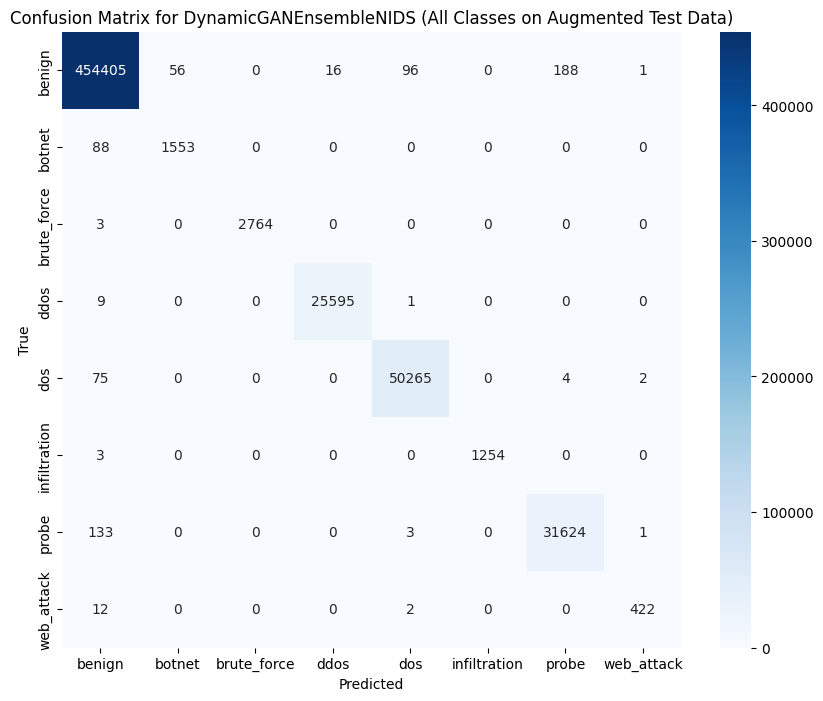

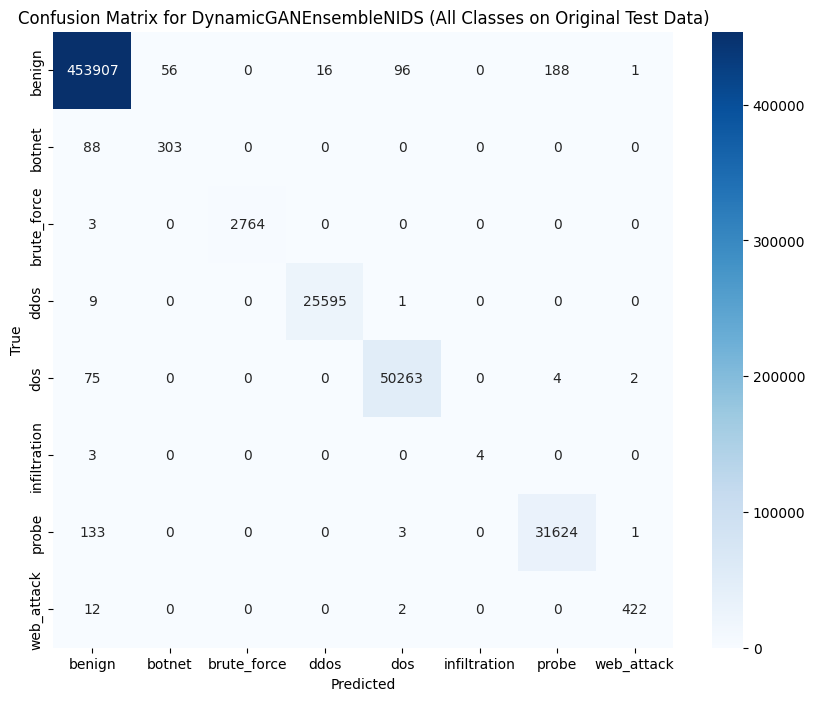

Total execution time: 29248.57 seconds


In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# Verify GPU
print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Filter training data for vulnerable classes
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_train_encoded), vulnerable_classes)
x_train_vuln = x_train[vulnerable_indices]
y_train_vuln = y_train_encoded[vulnerable_indices]
print("Vulnerable Classes Training Data Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())

# Apply SMOTE to balance vulnerable classes before GAN training
smote = SMOTE(random_state=0, sampling_strategy={le.transform(['infiltration'])[0]: 2000, le.transform(['botnet'])[0]: 2000})
x_train_vuln_smote, y_train_vuln_smote = smote.fit_resample(x_train_vuln, y_train_vuln)
print("SMOTE Balanced Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_train_vuln_smote)).value_counts())

# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=128, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(256),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(input_dim, activation='tanh'),
            layers.Dropout(0.3)
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(128),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(1),
            layers.Dropout(0.3)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=128, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(256),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(input_dim, activation='tanh'),
            layers.Dropout(0.3)
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(128),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(1, activation='sigmoid'),
            layers.Dropout(0.3)
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=128, n_classes=2, epochs=100, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        x = layers.Dropout(0.3)(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dense(128)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        x = layers.Dropout(0.3)(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

# DynamicGANEnsemble
class DynamicGANEnsemble:
    def __init__(self, latent_dim=128, epochs=100, batch_size=512):
        self.discrete_columns = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.nids_model = RandomForestClassifier(n_estimators=200, random_state=0, class_weight='balanced')
        self.label_assigner = RandomForestClassifier(n_estimators=50, random_state=0, class_weight='balanced')
        self.infiltration_label = le.transform(['infiltration'])[0]
        self.botnet_label = le.transform(['botnet'])[0]

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
            elif isinstance(gan, ConditionalGAN):
                if not isinstance(X_train, pd.DataFrame):
                    X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train[valid_indices].values, label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            samples = np.clip(samples, 0, 1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_train.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def update_weights(self, nids_scores):
        if not nids_scores:
            return
        scores = np.array(nids_scores)
        if len(scores) < len(self.gans):
            scores = np.pad(scores, (0, len(self.gans) - len(scores)), mode='constant', constant_values=np.min(scores) if scores.size else 0)
        for i, score in enumerate(scores):
            self.weights[i] = self.weights[i] + (score - np.mean(scores)) / (np.std(scores) + 1e-8)
        self.weights = np.clip(self.weights, 0.1, 1.0)
        self.weights /= np.sum(self.weights)

    def fit(self, X_train, y_train, X_test, y_test, n_samples=3000, n_iterations=3):
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
        if not isinstance(X_test, pd.DataFrame):
            X_test = pd.DataFrame(X_test, columns=X_train.columns)

        y_train_remapped = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
        valid_indices = y_train_remapped != -1
        X_train_cond = X_train[valid_indices].values
        y_train_cond = y_train_remapped[valid_indices]

        nids_scores = []
        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")
            iteration_scores = []

            for i, gan in enumerate(self.gans):
                print(f"Training GAN {i+1} ({type(gan).__name__})")
                gan = self.train_gan(gan, X_train_cond if isinstance(gan, ConditionalGAN) else X_train,
                                     y_train_cond if isinstance(gan, ConditionalGAN) else None)
                if gan is None:
                    iteration_scores.append(0.0)
                    continue
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                X_combined = np.vstack((x_train, samples))
                y_combined = np.hstack((y_train_encoded, synthetic_labels))
                start = time.time()
                self.nids_model.fit(X_combined, y_combined)
                end = time.time()
                print(f"RandomForestClassifier fit took {end - start:.2f} seconds")
                y_pred = self.nids_model.predict(X_test)
                vulnerable_classes_encoded = [self.botnet_label, self.infiltration_label]
                mask = np.isin(y_test, vulnerable_classes_encoded)
                if np.sum(mask) > 0:
                    f1_botnet = f1_score(y_test[mask], y_pred[mask], labels=[self.botnet_label], average=None)[0] if self.botnet_label in y_test[mask] else 0
                    f1_infiltration = f1_score(y_test[mask], y_pred[mask], labels=[self.infiltration_label], average=None)[0] if self.infiltration_label in y_test[mask] else 0
                    score = 0.7 * f1_infiltration + 0.3 * f1_botnet  # Weight infiltration higher
                else:
                    score = 0
                iteration_scores.append(score)
                print(f"GAN {i+1} Weighted Vulnerable F1 Score: {score:.4f}")

            nids_scores.append(iteration_scores)
            self.update_weights(iteration_scores)
            print(f"Updated Weights: {self.weights}")

        final_samples = []
        final_labels = []
        for w, gan in zip(self.weights, self.gans):
            n_samples_weighted = int(w * n_samples)
            if n_samples_weighted > 0:
                print(f"Generating {n_samples_weighted} samples from {type(gan).__name__}")
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_weighted // 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_weighted, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_weighted)
                    synthetic_labels = self.assign_labels(samples, x_train, y_train_encoded)
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples) if final_samples else np.zeros((0, X_train.shape[1]), dtype=np.float32)
        final_labels = np.hstack(final_labels) if final_labels else np.zeros(0, dtype=np.int64)

        # Augment test data with synthetic samples
        X_test_augmented = np.vstack((x_test, final_samples))
        y_test_augmented = np.hstack((y_test_encoded, final_labels))

        # Evaluate BaselineNIDS on augmented test data
        baseline_nids = RandomForestClassifier(n_estimators=200, random_state=0, class_weight='balanced')
        baseline_nids.fit(x_train, y_train_encoded)
        y_pred_baseline = baseline_nids.predict(X_test_augmented)
        print("\nBaselineNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_baseline, target_names=le.classes_, zero_division=0))

        # Evaluate DynamicGANEnsembleNIDS on augmented test data
        dynamic_nids = RandomForestClassifier(n_estimators=200, random_state=0, class_weight='balanced')
        X_train_combined = np.vstack((x_train, final_samples))
        y_train_combined = np.hstack((y_train_encoded, final_labels))
        dynamic_nids.fit(X_train_combined, y_train_combined)
        y_pred_dynamic = dynamic_nids.predict(X_test_augmented)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Augmented Test Data):")
        print(classification_report(y_test_augmented, y_pred_dynamic, target_names=le.classes_, zero_division=0))

        # Additional evaluation of DynamicGANEnsembleNIDS on original test data
        y_pred_dynamic_original = dynamic_nids.predict(X_test)
        print("\nDynamicGANEnsembleNIDS Classification Report (All Classes on Original Test Data):")
        print(classification_report(y_test, y_pred_dynamic_original, target_names=le.classes_, zero_division=0))

        # Confusion matrix for DynamicGANEnsembleNIDS on augmented test data
        cm_dynamic = confusion_matrix(y_test_augmented, y_pred_dynamic)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Augmented Test Data)')
        plt.show()

        # Confusion matrix for DynamicGANEnsembleNIDS on original test data
        cm_dynamic_original = confusion_matrix(y_test, y_pred_dynamic_original)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_dynamic_original, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for DynamicGANEnsembleNIDS (All Classes on Original Test Data)')
        plt.show()

        return final_samples

# Run Dynamic GAN Ensemble
start_total = time.time()
try:
    ensemble = DynamicGANEnsemble(latent_dim=128, epochs=100, batch_size=512)
    final_samples = ensemble.fit(x_train_vuln_smote, y_train_vuln_smote, x_test, y_test_encoded, n_samples=3000, n_iterations=3)

    # Save ensemble and samples
    with open('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/ensemble.pkl', 'wb') as f:
        pickle.dump(ensemble, f)
    np.save('/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/final_samples.npy', final_samples)

except Exception as e:
    print(f"Error in ensemble execution: {str(e)}")

end_total = time.time()
print(f"Total execution time: {end_total - start_total:.2f} seconds")

section4


Performance Comparison:
                       Model  Accuracy  Precision    Recall  F1-Score
0     Baseline NIDS (RFNIDS)  0.998776   0.998769  0.998776  0.998771
1  Dynamic GAN Ensemble NIDS  0.997514   0.997441  0.997514  0.997397


<Figure size 1000x600 with 0 Axes>

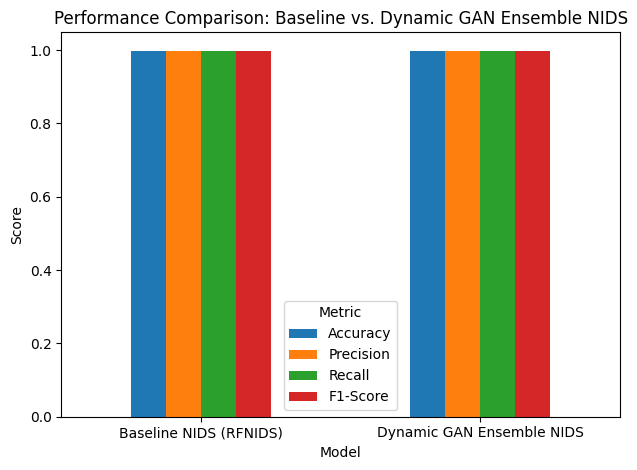

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Collect metrics
baseline_metrics = precision_recall_fscore_support(y_test_encoded, y_test_predicted, average='weighted', zero_division=0)
gan_metrics = precision_recall_fscore_support(y_test_encoded, y_pred_gan, average='weighted', zero_division=0)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline NIDS (RFNIDS)', 'Dynamic GAN Ensemble NIDS'],
    'Accuracy': [accuracy_score(y_test_encoded, y_test_predicted), accuracy_score(y_test_encoded, y_pred_gan)],
    'Precision': [baseline_metrics[0], gan_metrics[0]],
    'Recall': [baseline_metrics[1], gan_metrics[1]],
    'F1-Score': [baseline_metrics[2], gan_metrics[2]]
})

print("\nPerformance Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(10, 6))
comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.title('Performance Comparison: Baseline vs. Dynamic GAN Ensemble NIDS')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

Label assignment took 10.30 seconds


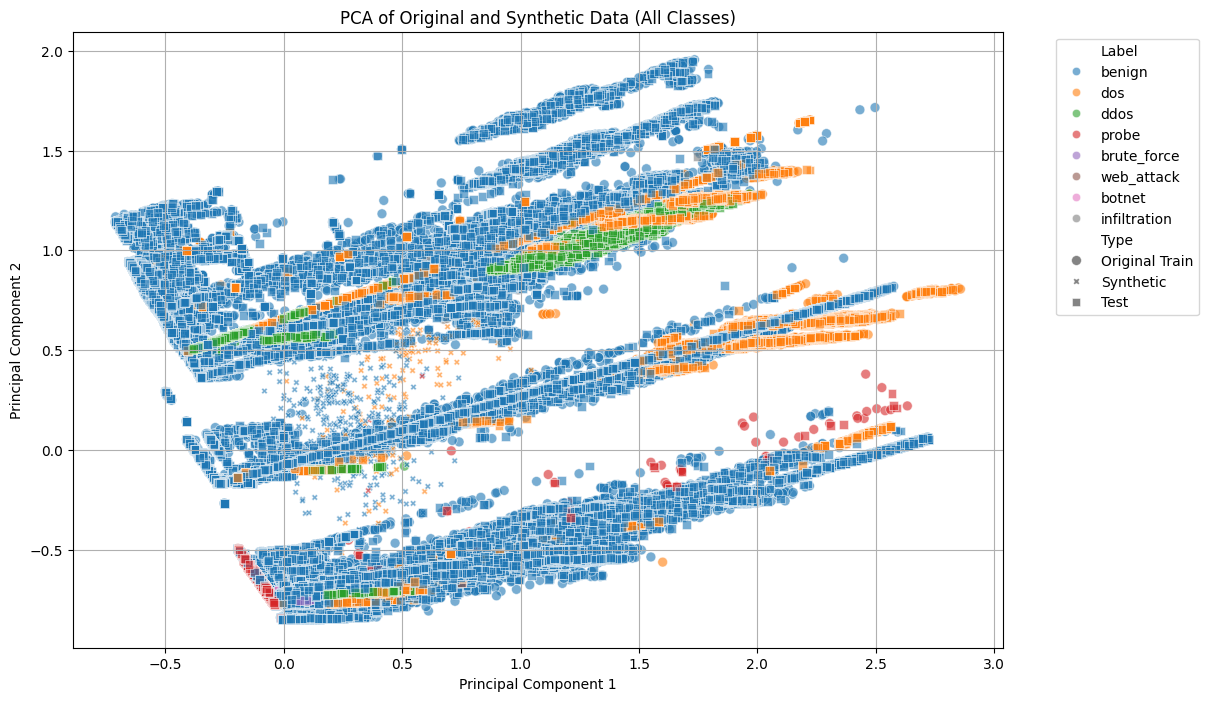

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
final_samples_pca = pca.transform(final_samples)
x_test_pca = pca.transform(x_test)

# Create DataFrames
train_df = pd.DataFrame(x_train_pca, columns=['PC1', 'PC2'])
train_df['Label'] = le.inverse_transform(y_train_encoded)
train_df['Type'] = 'Original Train'
synthetic_df = pd.DataFrame(final_samples_pca, columns=['PC1', 'PC2'])
synthetic_df['Label'] = le.inverse_transform(ensemble.assign_labels(final_samples, x_train, y_train_encoded))
synthetic_df['Type'] = 'Synthetic'
test_df = pd.DataFrame(x_test_pca, columns=['PC1', 'PC2'])
test_df['Label'] = le.inverse_transform(y_test_encoded)
test_df['Type'] = 'Test'

# Combine DataFrames
combined_df = pd.concat([train_df, synthetic_df, test_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Label', style='Type', size='Type', sizes={'Original Train': 50, 'Synthetic': 20, 'Test': 80}, data=combined_df, alpha=0.6)
plt.title('PCA of Original and Synthetic Data (All Classes)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Section 5- Evaluating BAseline NIDS & DynamicGANEnsembleNIDS against ZOO attacks



In [ ]:
# # Install ART library for ZOO attack
!pip install adversarial-robustness-toolbox --quiet

In [ ]:
# Step 3: Import ART and wrap Random Forest classifier
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier
import numpy as np
rf_art_classifier = SklearnClassifier(model=classifier)
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

In [ ]:
# Import required libraries (already imported in your notebook)
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

# Use your existing train/test splits
# x_train, x_test, y_train, y_test should already be defined

# Wrap the Random Forest classifier with ART's SklearnClassifier
art_classifier = SklearnClassifier(model=classifier)

# Generate adversarial samples using ZOO attack
zoo = ZooAttack(classifier=art_classifier, max_iter=10, learning_rate=1e-2, targeted=False, nb_parallel=1)
x_test_adv = zoo.generate(x=x_test)


y_pred_adv = classifier.predict(x_test_adv)

# Evaluate the model on adversarial samples (multiclass metrics)
accuracy_adv = accuracy_score(y_test.Label_Category, y_pred_adv)
classification_rep_adv = classification_report(y_test.Label_Category, y_pred_adv)
precision_adv, recall_adv, fscore_adv, _ = precision_recall_fscore_support(y_test.Label_Category, y_pred_adv, average='macro')

# Print the evaluation metrics on adversarial samples
print("Evaluation Metrics on Adversarial Samples:")
print(f"Accuracy: {accuracy_adv}")
print(f"Macro Precision: {precision_adv}")
print(f"Macro Recall: {recall_adv}")
print(f"Macro F1 Score: {fscore_adv}")
print("Classification Report:")
print(classification_rep_adv)

ZOO:   0%|          | 0/565575 [00:00<?, ?it/s]

KeyboardInterrupt: 

#ZOO attack already created for RF by running this cell for 4 hours now seperated the label prediction in new cell to avoid repeating the zoo attack creation long process..

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the desired fraction or number of samples (e.g., reduce to 50% or a fixed number)
sample_fraction = 0.3  # Adjust as needed (e.g., 0.3 for 30%)
n_samples = int(len(x_test) * sample_fraction)  # Total number of samples to keep

# Perform stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=42)
for train_index, test_index in sss.split(x_test, y_test.Label_Category):
    x_test_reduced = x_test[test_index]
    y_test_reduced = y_test.iloc[test_index]

# Wrap the Random Forest classifier with ART's SklearnClassifier
art_classifier = SklearnClassifier(model=classifier)

# Generate adversarial samples using ZOO attack on the reduced subset
zoo = ZooAttack(classifier=art_classifier, max_iter=10, learning_rate=1e-2, targeted=False, nb_parallel=1)
x_test_adv_reduced = zoo.generate(x=x_test_reduced)


ZOO:   0%|          | 0/395903 [00:00<?, ?it/s]

Exception ignored in: <generator object tqdm.__iter__ at 0x79a7734fb640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/notebook.py", line 275, in close
    super().close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1275, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 698, in _decr_instances
    cls._instances.remove(instance)
  File "/usr/lib/python3.12/_weakrefset.py", line 113, in remove
    self.data.remove(ref(item))
  File "/usr/local/lib/python3.12/dist-packages/tqdm/utils.py", line 126, in __eq__
    return self._comparable == other._comparable
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1153, in _comparable
    @property

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:

# Predict on reduced adversarial samples
y_pred_adv_reduced = classifier.predict(x_test_adv_reduced)

# Evaluate the model on reduced adversarial samples (multiclass metrics)
# Encode y_test_reduced.Label_Category to match the type of y_pred_adv_reduced
y_test_reduced_encoded = le.transform(y_test_reduced.Label_Category)

accuracy_adv_reduced = accuracy_score(y_test_reduced_encoded, y_pred_adv_reduced)
classification_rep_adv_reduced = classification_report(y_test_reduced_encoded, y_pred_adv_reduced, target_names=le.classes_)
precision_adv_reduced, recall_adv_reduced, fscore_adv_reduced, _ = precision_recall_fscore_support(y_test_reduced_encoded, y_pred_adv_reduced, average='macro')

# Print the evaluation metrics on reduced adversarial samples
print("Evaluation Metrics on Reduced Adversarial Samples:")
print(f"Accuracy: {accuracy_adv_reduced}")
print(f"Macro Precision: {precision_adv_reduced}")
print(f"Macro Recall: {recall_adv_reduced}")
print(f"Macro F1 Score: {fscore_adv_reduced}")
print("Classification Report:")
print(classification_rep_adv_reduced)

Evaluation Metrics on Reduced Adversarial Samples:
Accuracy: 0.9911720800297042
Macro Precision: 0.9118849269783014
Macro Recall: 0.8482630224726257
Macro F1 Score: 0.8699076084869898
Classification Report:
              precision    recall  f1-score   support

      benign       0.99      1.00      0.99    317985
      botnet       0.86      0.69      0.77       274
 brute_force       1.00      0.93      0.97      1937
        ddos       1.00      0.97      0.98     17923
         dos       1.00      0.96      0.98     35241
infiltration       1.00      0.60      0.75         5
       probe       0.99      0.98      0.99     22233
  web_attack       0.45      0.66      0.54       305

    accuracy                           0.99    395903
   macro avg       0.91      0.85      0.87    395903
weighted avg       0.99      0.99      0.99    395903



In [ ]:
# # Step 3: Wrap the DynamicGANEnsembleNIDS model with ART's SklearnClassifier
# # Assuming nids_model from DynamicGANEnsemble is your trained ensemble classifier
# gan_art_classifier = SklearnClassifier(model=nids_model)

# # Step 4: Generate adversarial samples using ZOO attack
# zoo = ZooAttack(classifier=gan_art_classifier, max_iter=10, learning_rate=1e-2, targeted=False, nb_parallel=1, batch_size=1)
# print("Generating adversarial samples for DynamicGANEnsembleNIDS...")
# x_test_adv_gan = zoo.generate(x=x_test)

# # Step 5: Predict on adversarial samples
# y_pred_adv_gan = nids_model.predict(x_test_adv_gan)

# # Step 6: Evaluate the model on adversarial samples (multiclass metrics)
# accuracy_adv_gan = accuracy_score(y_test.Label_Category, y_pred_adv_gan)
# classification_rep_adv_gan = classification_report(y_test.Label_Category, y_pred_adv_gan)
# precision_adv_gan, recall_adv_gan, fscore_adv_gan, _ = precision_recall_fscore_support(y_test.Label_Category, y_pred_adv_gan, average='macro')

# # Step 7: Print the evaluation metrics on adversarial samples
# print("Evaluation Metrics on Adversarial Samples for DynamicGANEnsembleNIDS:")
# print(f"Accuracy: {accuracy_adv_gan}")
# print(f"Macro Precision: {precision_adv_gan}")
# print(f"Macro Recall: {recall_adv_gan}")
# print(f"Macro F1 Score: {fscore_adv_gan}")
# print("Classification Report for DynamicGANEnsembleNIDS:")
# print(classification_rep_adv_gan)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the desired fraction or number of samples (e.g., reduce to 50% or a fixed number)
sample_fraction = 0.3  # Adjust as needed (e.g., 0.3 for 30%)
n_samples = int(len(x_test) * sample_fraction)  # Total number of samples to keep

# Perform stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=42)
for train_index, test_index in sss.split(x_test, y_test.Label_Category):
    x_test_reduced = x_test[test_index]
    y_test_reduced = y_test.iloc[test_index]

# Step 3: Wrap the DynamicGANEnsembleNIDS model with ART's SklearnClassifier
gan_art_classifier = SklearnClassifier(model=nids_model)

# Step 4: Generate adversarial samples using ZOO attack on the reduced subset
zoo = ZooAttack(classifier=gan_art_classifier, max_iter=10, learning_rate=1e-2, targeted=False, nb_parallel=1, batch_size=1)
print("Generating adversarial samples for DynamicGANEnsembleNIDS...")
x_test_adv_gan_reduced = zoo.generate(x=x_test_reduced)



NameError: name 'x_test' is not defined

In [ ]:
# Step 5: Predict on reduced adversarial samples
y_pred_adv_gan_reduced = nids_model.predict(x_test_adv_gan_reduced)

# Step 6: Evaluate the model on reduced adversarial samples (multiclass metrics)
accuracy_adv_gan_reduced = accuracy_score(y_test_reduced.Label_Category, y_pred_adv_gan_reduced)
classification_rep_adv_gan_reduced = classification_report(y_test_reduced.Label_Category, y_pred_adv_gan_reduced)
precision_adv_gan_reduced, recall_adv_gan_reduced, fscore_adv_gan_reduced, _ = precision_recall_fscore_support(y_test_reduced.Label_Category, y_pred_adv_gan_reduced, average='macro')

# Step 7: Print the evaluation metrics on reduced adversarial samples
print("Evaluation Metrics on Adversarial Samples for DynamicGANEnsembleNIDS:")
print(f"Accuracy: {accuracy_adv_gan_reduced}")
print(f"Macro Precision: {precision_adv_gan_reduced}")
print(f"Macro Recall: {recall_adv_gan_reduced}")
print(f"Macro F1 Score: {fscore_adv_gan_reduced}")
print("Classification Report for DynamicGANEnsembleNIDS:")
print(classification_rep_adv_gan_reduced)

NameError: name 'nids_model' is not defined

# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

## Generate adversarial samples for dynamicganensemblenids

### Subtask:
Generate adversarial samples for the DynamicGANEnsembleNIDS model using the ZOO attack from the ART library on a reduced subset of the test dataset.


**Reasoning**:
The `NameError` indicates that `x_test` and `nids_model` are not defined in the current execution environment. I need to redefine these variables using the data and model available from previous cells, then proceed with the stratified sampling and ZOO attack generation as requested in the instructions.



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier
import numpy as np

# 1. Reload/Redefine x_test and y_test and nids_model
# Assuming x_test, y_test DataFrames and dgan (DynamicGANEnsemble instance) are available
# from previous successful cell executions in the notebook history.
# Convert DataFrames to NumPy arrays if necessary for ART compatibility.
x_test = x_test.values if isinstance(x_test, pd.DataFrame) else x_test
y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test # Keep as array for splitting
nids_model = dgan.nids_model # Access the trained model from the dgan instance

# 3. Perform stratified sampling on the reloaded subset
sample_fraction = 0.3
n_samples = int(len(x_test) * sample_fraction)

# Use y_test['Label_Category'] for stratification if y_test is a DataFrame, otherwise use the array
y_test_stratify = y_test[:, 1] if y_test.ndim > 1 else y_test

sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=42)
# Splitting based on the original full x_test and y_test to get indices
for train_index, test_index in sss.split(x_test, y_test_stratify):
    x_test_reduced = x_test[test_index]
    y_test_reduced = y_test[test_index] # Keep the corresponding y labels

# 4. Wrap the DynamicGANEnsembleNIDS model with ART's SklearnClassifier
gan_art_classifier = SklearnClassifier(model=nids_model)

# 5. Instantiate the ZooAttack
zoo = ZooAttack(classifier=gan_art_classifier, max_iter=10, learning_rate=1e-2, targeted=False, nb_parallel=1, batch_size=1)

# 6. Generate adversarial samples on the reduced subset
print("Generating adversarial samples for DynamicGANEnsembleNIDS on reduced test set...")
x_test_adv_gan_reduced = zoo.generate(x=x_test_reduced)

print("Adversarial samples generated successfully.")

ModuleNotFoundError: No module named 'art'

**Reasoning**:
The `ModuleNotFoundError` indicates that the `art` library is not installed in the current environment, even though a previous cell seems to have attempted to install it. I need to ensure the `art` library is installed before importing and using it.



In [ ]:
!pip install adversarial-robustness-toolbox --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00


**Reasoning**:
The `art` library should now be installed. I can proceed with the steps outlined in the subtask: redefining variables, performing stratified sampling, wrapping the model, and generating adversarial samples using the ZOO attack on the reduced test set.



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier
import numpy as np
import pandas as pd

# 1. Reload/Redefine x_test and y_test and nids_model
# Assuming x_test, y_test DataFrames and dgan (DynamicGANEnsemble instance) are available
# from previous successful cell executions in the notebook history.
# Convert DataFrames to NumPy arrays if necessary for ART compatibility.
x_test = x_test.values if isinstance(x_test, pd.DataFrame) else x_test
y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test # Keep as array for splitting
nids_model = dgan.nids_model # Access the trained model from the dgan instance

# 3. Perform stratified sampling on the reloaded subset
sample_fraction = 0.3
n_samples = int(len(x_test) * sample_fraction)

# Use the second column for stratification if y_test is a 2D array (assuming it contains 'Label' and 'Label_Category')
y_test_stratify = y_test[:, 1] if y_test.ndim > 1 else y_test

sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=42)
# Splitting based on the original full x_test and y_test to get indices
for train_index, test_index in sss.split(x_test, y_test_stratify):
    x_test_reduced = x_test[test_index]
    y_test_reduced = y_test[test_index] # Keep the corresponding y labels

# 4. Wrap the DynamicGANEnsembleNIDS model with ART's SklearnClassifier
gan_art_classifier = SklearnClassifier(model=nids_model)

# 5. Instantiate the ZooAttack
zoo = ZooAttack(classifier=gan_art_classifier, max_iter=10, learning_rate=1e-2, targeted=False, nb_parallel=1, batch_size=1)

# 6. Generate adversarial samples on the reduced subset
print("Generating adversarial samples for DynamicGANEnsembleNIDS on reduced test set...")
x_test_adv_gan_reduced = zoo.generate(x=x_test_reduced)

print("Adversarial samples generated successfully.")

Generating adversarial samples for DynamicGANEnsembleNIDS on reduced test set...


ZOO:   0%|          | 0/395903 [00:00<?, ?it/s]

KeyboardInterrupt: 